In [1]:
from tifffile import TiffFile
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects
from scipy import optimize
import glob
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.morphology import binary_opening
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from alienlab.regression_func import residuals, exp_decay, regression_affine, regression_linear, get_affine_func

from readlif.reader import LifFile
import skimage


save_folder = '.'
import glob
import alienlab.plot
p = alienlab.plot.PlotFigure()
p.extension = ".pdf"
p.date = False
#p.save_folder = "G:/DREAM/from_github/thesis/Figures/OJIP/"
p.save_folder = "G:/DREAM/from_github/thesis/Intensity_paper/"

sigma_480 = 198 #m2/mol
sigma_405 = 415 #m2/mol
tau_relax = 0.014

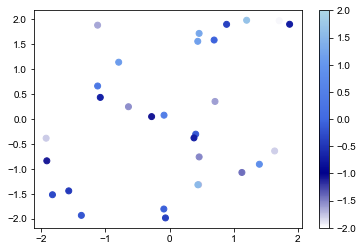

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

x,y,c = zip(*np.random.rand(30,3)*4-2)

cvals  = [-2., -1,0, 1, 2]
colors = ["w","darkblue","royalblue", 'cornflowerblue', 'lightblue']

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
blue_map = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

plt.scatter(x,y,c=c, cmap=blue_map, norm=norm)
plt.colorbar()
plt.show()

In [12]:
def exp_decay(parameters, xdata):
    '''
    Calculate an exponential decay of the form:
    S= a * exp(-xdata/b)
    '''
    A = parameters[0]
    tau = parameters[1]
    y0 = parameters[2]
    return A * np.exp(-xdata/tau) + y0


def simple_tau(fluo, time_array, sample_rate = 0):
    L = len(time_array) 
    if sample_rate==0:
        sample_rate = L/(time_array[-1]-time_array[0])
    fluo_transition = fluo
    time_transition = np.linspace(0, L - 1, L)
    x0 = [1e5, L/8, 1]
    OptimizeResult  = optimize.least_squares(residuals,  x0, bounds = (-1e9,1e9),
                                        args = (time_transition, fluo_transition, exp_decay))
    parameters_estimated = OptimizeResult.x
    tau = parameters_estimated[1]

    #conditions on tau too low or too high for the second, more accurate, fit, because we will fit on a signal that lasts 5*tau
    if tau >  L//10: #if too high
        tau =  L//10
    if tau < 3: #if too low, increase it
        tau = 5
    x0 = parameters_estimated #initial guess: parameters from previous fit
    #second fit
    OptimizeResult  = optimize.least_squares(residuals,  x0, bounds = (-1e9,1e9),
                                        args = (time_transition[0:int(tau*5)], fluo_transition[0: int(tau*5)], exp_decay))
    parameters_estimated = OptimizeResult.x
    parameters_estimated[1]/=sample_rate

    return parameters_estimated


@delayed
@wrap_non_picklable_objects
def simple_tau_parallel(fluo, time_array, sample_rate = 5):
    return simple_tau(fluo, time_array, sample_rate)[1]


D = 3


def LIF_ImgAndInfo (FilePath, StackNumber):
    ImageStacksObject = LifFile(FilePath)
    ImageStack = ImageStacksObject.get_image(StackNumber)    # Get the frames in the stack and save as a list of numpy arrays
    ImageStackNumpy = []
    meta = ImageStacksObject.image_list[StackNumber]
    for i in range (meta['dims'][3]):        
        IMG = ImageStack.get_frame(z=0, t=i, c=0)
        IMGnumpy = np.array(IMG)
        ImageStackNumpy.append(IMGnumpy)    ## Get name, laser power and dwell time
    Name = meta['name']
    PixelDwellTime = meta['settings']['PixelDwellTime']
    Zoom = meta['settings']['Zoom']
    
    dX = meta['scale_n'][1]

    return np.array(ImageStackNumpy), Name, float(PixelDwellTime), float(Zoom), float(dX), ImageStacksObject



    

def plot_map(I_000, I_000_map, save_name, limits = (0,0), tau = False):
    """display the results"""
    
    #crop the outliers for correct scaling of the colormap
    if limits==(0,0):
        Q1 = np.quantile(I_000, 0.01)
        Q3 = np.quantile(I_000, 0.995)
    else: 
        Q1 = limits[0]
        Q3 = limits[1]
    I_000_map[I_000_map <= Q1 ] = Q1
    I_000_map[I_000_map >= Q3 ] = Q3
    
    
    #map of intensities
    f = p.set_figure()
    if tau == False:
        image = plt.imshow((I_000_map), cmap = blue_map)
        
    else:
        image = plt.imshow((I_000_map), cmap = "viridis")

    H, L = I_000_map.shape
    scale = H//6
    rec = matplotlib.patches.Rectangle((H-H//6, L-L//9), scale, L//50, color = "lightgrey")
    ax = plt.gca()
    ax.add_patch(rec)
    
    plt.axis("off")
    divider = make_axes_locatable(plt.gca())
    axdef = divider.append_axes("bottom", "5%", pad="3%")
    cbar = plt.colorbar(image, cax=axdef, orientation = "horizontal")
    ax = plt.gca()
    ax.tick_params(labelsize=p.fonttick)
    if tau==False:
        plt.xlabel(r"$I$ ($\mathrm{E.m^{-2}.s^{-1}}$)", size = p.fontsize)
    else:
        plt.xlabel(r"$\tau$ ($\mathrm{\mu s}$)",  size = p.fontsize)

    plt.savefig(p.save_folder + "/" +save_name + p.extension)
    
    
    # histogram of intensities
    I_000_distrib = I_000[(I_000>Q1)*(I_000<Q3)].flatten()

    
    if tau==False:
        fig = p.set_figure("%d", "%d")

        plt.xlabel(r"$I$ ($\mathrm{E.m^{-2}.s^{-1}}$)")
    else:
        fig = p.set_figure("%0.1f", "%d")

        plt.xlabel(r"$\tau$ ($\mathrm{\mu s}$)")
    ax = plt.gca()

    plt.ylabel("")
    ax.tick_params(axis='both', which='major', direction = 'in', top = True, right = True)
    _, bins, _ = plt.hist(I_000_distrib, 15, density= False, alpha=1, facecolor = "white", edgecolor = "black")

    plt.savefig(p.save_folder + "/hist_" + save_name + p.extension)
    
    np.savetxt(p.save_folder + "/" + save_name + ".csv", I_000_map, delimiter=",")


    return I_000_map, I_000_distrib

In [13]:
file = glob.glob("../data/confocalX/*.lif")[0]
k = 43
volume, Name, PixelDwellTime, Zoom, dx, meta = LIF_ImgAndInfo(file, k)


17.210356743945
../data/confocalX\Sequence Activation Reading Dronpa.lif


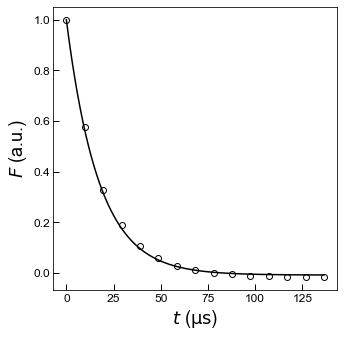

<Figure size 432x288 with 0 Axes>

In [5]:

fig = p.set_figure("%d", "%0.1f")    


name = os.path.split(file)[1][:-4]

K = 5
D = 2 #downscale
dwell_time = 4.88e-6 #sec

for j, k in enumerate([5]):
    volume, Name, PixelDwellTime, Zoom, dx, meta = LIF_ImgAndInfo(file, k)

    time = np.linspace(0, len(video)-1, len(video))*PixelDwellTime #generate time array from framerate


    v_ref = np.mean(volume[0:K], axis = 0)
    mask = v_ref>np.mean(v_ref)


    im_ref = downscale_local_mean(v_ref, (D, D))


    if k==5:
        mask = im_ref > np.mean(im_ref)
        mask = binary_opening(mask)

    else:
        dx = lsm_metadata["DimensionX"]
        dy  = lsm_metadata["DimensionY"]
        px = lsm_metadata["VoxelSizeX"]
        S = 3*1e-6//px + 1
        mask = np.zeros((im_ref.shape))
        V = 2*D
        mask[int(dx//V-S//V):int(dx//V+S//V), int(dy//V-S//V):int(dy//V+S//V)]=1
        mask = mask.astype(bool)


    video = np.copy(volume)
    video_downscaled = []
    for i in range(video.shape[0]):
        video_downscaled.append(downscale_local_mean(video[i], (D, D)))
    video_downscaled = np.array(video_downscaled)
    init_shape = np.copy(video_downscaled.shape)
    L, H = init_shape[1:]

    video_downscaled = video_downscaled.reshape(video_downscaled.shape[0], -1)

    to_evaluate = video_downscaled[:,mask.flatten()]

    x = np.linspace(0, len(time)-1, len(time))*PixelDwellTime*1e6
    y= np.mean(to_evaluate, axis = 1)
    m = np.mean(y[-20:])
    y=(y-m)/(y[0]-m)

    params = simple_tau(y, x, sample_rate = 0)
    print(params[1])
    print(file)
    K=2
    y=y[::K]
    x=x[::K]
    x2 = np.linspace(x.min(), x.max(), 1024)
    plt.plot(x2, exp_decay(params, x2), 'k')
    plt.plot(x, y, marker = ["o", "^"][j], markeredgecolor="k", color="none",
            label = "dwell_time: %0.1e s "%(PixelDwellTime))
    plt.xlabel(r"$t$ ($\mathrm{\mu s}$)")
    plt.ylabel(r"$F$ (a.u.)")
    p.save_name ="solution_%d_mean_time_response"
    p.saving(fig)



In [6]:
def crop(im, x,y):
    L,H =im.shape
    dl = int((L-x*L)//2)
    dh = int((H-y*H)//2)
    print(dl, dh)
    im = im[dl:L-dl,dh:H-dh]
    return im


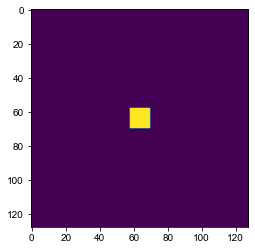

In [7]:
dx = 256
dy  = 256
dp = 290/256*1e-6
S = 30*1e-6/dp + 1
mask = np.zeros((im_ref.shape))
V = 2*D
mask[int(dx//V-S//V):int(dx//V+S//V), int(dy//V-S//V):int(dy//V+S//V)]=1

plt.figure()
plt.imshow(mask)

(30, 256, 256) 4.875e-06 1.0 0.8774193548387097
(78, 75)
(30, 5850)
29.039698925029057
173.9172662755145
(30, 256, 256) 4.875e-06 2.0 1.7548387096774194
(78, 75)
(30, 5850)
10.16153242911908
497.0219881434643


C:\Users\Alienor\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


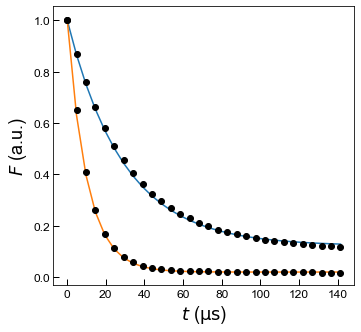

<Figure size 1224x648 with 0 Axes>

In [14]:

fig = p.set_figure("%d", "%0.1f")
ax = plt.gca()
plt.xlabel('$t$ ($\mathrm{\mu s}$)')
plt.ylabel("$F$ (a.u.)")



for j, k in enumerate([58, 5]):
    name = os.path.split(file)[1][:-4] + "_%d"%k
    plt.close('all')
    K = 5
    D = 2
    volume, Name, PixelDwellTime, Zoom, dx, meta = LIF_ImgAndInfo(file, k)
    print(volume.shape, PixelDwellTime, Zoom, dx)
    volume = volume[:,100:256, 50:200]

    time = np.linspace(0, len(video)-1, len(video))*PixelDwellTime #generate time array from framerate
    v_ref = np.mean(volume[0:K], axis = 0)
    mask = v_ref>np.mean(v_ref)


    im_ref = downscale_local_mean(v_ref, (D, D))


    
    if k in [5, 2, 28]:

        im_ref = downscale_local_mean(np.mean(volume[0:K], axis = 0), (D, D))

        threshold = skimage.filters.threshold_li(im_ref) #<----- replace here for the correct thresholding value, the computations will only be performed where pixel_value>threshold
        #select it from the image that best matches a mask, and copy the corresponding function name printed above

        mask = im_ref>threshold
        mask = binary_opening(mask,  np.ones((k,k)))


    else:
        dx = 256
        dy  = 256
        dp = 290/256*1e-6
        S = 200*1e-6/dp + 1
        mask = np.zeros((im_ref.shape))
        V = 2*D
        mask[int(dx//V-S//V):int(dx//V+S//V), int(dy//V-S//V):int(dy//V+S//V)]=1

        mask = mask.astype(bool)
        p.save_name = name  +  "_mask_ref"
        p.saving(fig)

    video = np.copy(volume)
    video_downscaled = []
    for i in range(video.shape[0]):
        video_downscaled.append(downscale_local_mean(video[i], (D, D)))
    video_downscaled = np.array(video_downscaled)
    init_shape = np.copy(video_downscaled.shape)
    L, H = init_shape[1:]

    video_downscaled = video_downscaled.reshape(video_downscaled.shape[0], -1)
    print(mask.shape)
    print(video_downscaled.shape)
    to_evaluate = video_downscaled[:,mask.flatten()]
    
   
    x = np.linspace(0, len(time)-1, len(time))*PixelDwellTime*1e6
    y= np.mean(to_evaluate, axis = 1)
    y/=y[0]

    params = simple_tau(y, x, sample_rate = 0)
    print(params[1])
    print(1e6/(sigma_480*params[1]))

    ax.plot(x, exp_decay(params, x))
    ax.plot(x, y, "ok",
            label = "dwell_time: %0.1e s "%(PixelDwellTime))
    
p.save_name = name + "_mean_time_response"
p.saving(fig)



(30, 256, 256) 4.875e-06 5.00001271568989 0.22794058823529414
12 0
(256, 256)
(30, 65536)
11.989374300558227


100%|████████████████████████████████████████████████████████████████████████████| 5835/5835 [00:01<00:00, 3149.31it/s]


12 0
12 0
(30, 256, 256) 4.875e-06 5.00001271568989 0.22794058823529414
12 0
(256, 256)
(30, 65536)
22.742096990237407


100%|██████████████████████████████████████████████████████████████████████████| 14121/14121 [00:08<00:00, 1597.51it/s]


12 0
12 0


C:\Users\Alienor\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


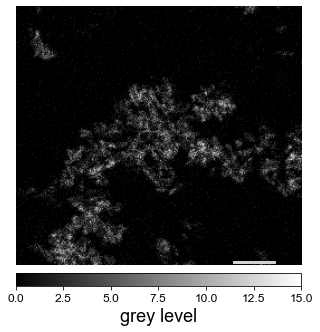

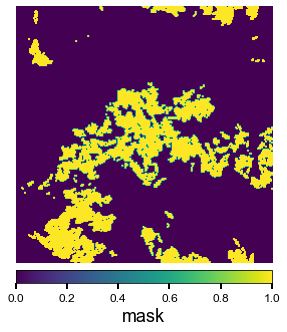

<Figure size 1224x648 with 0 Axes>

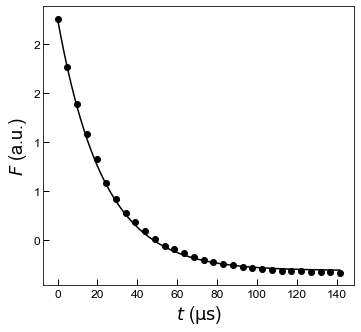

<Figure size 1224x648 with 0 Axes>

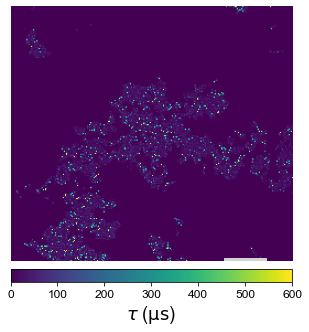

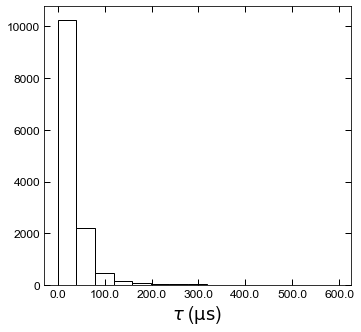

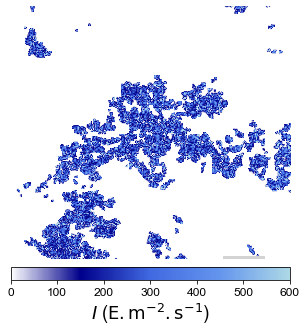

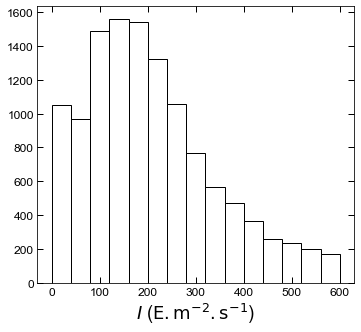

In [16]:
I_maps = []


for k in [28, 49]:
    name = os.path.split(file)[1][:-4] + "_%d"%k
    plt.close('all')
    K = 5
    D = 1
    volume, Name, PixelDwellTime, Zoom, dx, meta = LIF_ImgAndInfo(file, k)
    print(volume.shape, PixelDwellTime, Zoom, 1/dx)
    u, dx, dy = volume.shape
    #volume = volume[:,100:256, 50:200]

    time = np.linspace(0, len(volume)-1, len(volume))*dwell_time #generate time array from framerate
    v_ref = np.mean(volume[0:K], axis = 0)
    mask = v_ref>np.mean(v_ref)


    im_ref = downscale_local_mean(v_ref, (D, D))


    p.set_figure()
    plt.axis("off")
    im = crop(volume[0], 0.9, 1)
    image = plt.imshow(im, cmap = "gray")
    H, L = im.shape
    scale = H//6
    rec = matplotlib.patches.Rectangle((H-H//6, L-L//9), scale, L//100, color = "lightgrey")
    ax = plt.gca()
    ax.add_patch(rec)
    divider = make_axes_locatable(plt.gca())
    axdef = divider.append_axes("bottom", "5%", pad="3%")
    cbar = plt.colorbar(image, cax=axdef, orientation = "horizontal")
    ax = plt.gca()
    plt.xlabel("grey level", size=p.fontsize)

    ax.tick_params(labelsize=p.fonttick)


    plt.savefig(p.save_folder + "/layer_%d_intensity"%k + p.extension)

    im_ref = downscale_local_mean(np.mean(volume[0:K], axis = 0), (D, D))

    threshold = skimage.filters.threshold_li(im_ref) #<----- replace here for the correct thresholding value, the computations will only be performed where pixel_value>threshold
    #select it from the image that best matches a mask, and copy the corresponding function name printed above

    mask = im_ref>threshold
    mask = binary_opening(mask,  np.ones((2,2)))

    fig = p.image_scale(mask, label = 'mask')

    p.save_name = name  +  "_mask_ref"
    p.saving(fig)


    video = np.copy(volume)
    video_downscaled = []
    for i in range(video.shape[0]):
        video_downscaled.append(downscale_local_mean(video[i], (D, D)))
    video_downscaled = np.array(video_downscaled)
    init_shape = np.copy(video_downscaled.shape)
    L, H = init_shape[1:]

    video_downscaled = video_downscaled.reshape(video_downscaled.shape[0], -1)
    print(mask.shape)
    print(video_downscaled.shape)
    to_evaluate = video_downscaled[:,mask.flatten()]

    fig = p.set_figure("%d", "%d")    
    x = np.linspace(0, len(time)-1, len(time))*dwell_time*1e6
    y= np.mean(to_evaluate, axis = 1)

    params = simple_tau(y, x, sample_rate = 0)
    print(params[1])

    x2 = np.linspace(x.min(), x.max(), 1024)
    plt.plot(x2, exp_decay(params, x2), "k")

    plt.plot(x, y, "ok",
            label = "dwell_time: %0.1e s "%(dwell_time))
    plt.xlabel(r"$t$ ($\mathrm{\mu s}$)")
    plt.ylabel("$F$ (a.u.)")
    p.save_name = name + "_mean_time_response"
    p.saving(fig)

    start = 0
    stop = -1
    """
    for i in range(to_evaluate.shape[1]):
                print(params[1])
                plt.figure()
                y, x = to_evaluate[start:stop,i], time[start:stop]
                params = simple_tau(y, x, sample_rate =  0)
                plt.plot(x, y)
                plt.plot(x, exp_decay(params, x), 'k')
                plt.show()
    """

    tau_lists = Parallel(n_jobs = -1 )(simple_tau_parallel(to_evaluate[start:stop,i], time[start:stop], sample_rate = 1/dwell_time) for i in tqdm(range(to_evaluate.shape[1])))

    plt.set_cmap('viridis')

    tau_480 = np.array(tau_lists)
    tau_480_map = np.zeros(mask.shape)
    tau_480_map[mask] = tau_480
    I, dis = plot_map(tau_480*1e6, crop(tau_480_map*1e6, 0.9, 1),  name + "_tau_pred", limits = (0, 600), tau=True)

    I_480 = (1/tau_480 - tau_relax)/sigma_480
    I_480_map = np.zeros(mask.shape)
    I_480_map[mask] = I_480

    I, dis = plot_map(I_480, crop(I_480_map, 0.9, 1),  name + "_intensity_pred",limits = (0, 600),)
    I_maps.append(I)


In [10]:
bloc_shape = (200, I_maps[0].shape[0], I_maps[0].shape[1])
bloc = np.zeros(bloc_shape)
bloc2 = np.zeros(bloc_shape)

I1 = skimage.filters.gaussian(I_maps[1])
I1[I1==0] = np.min(I1[I1!=0])
bloc[-5] = I1
I0 = skimage.filters.gaussian(I_maps[0])
I0[I0==0] = np.min(I0[I0!=0])
bloc[5] = I0

bloc2[5:-5,-1,:] = 1
bloc2[5:-5,:,0] = 1
bloc2[5:-5,:,-1] = 1


C:\Users\Alienor\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Alienor\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


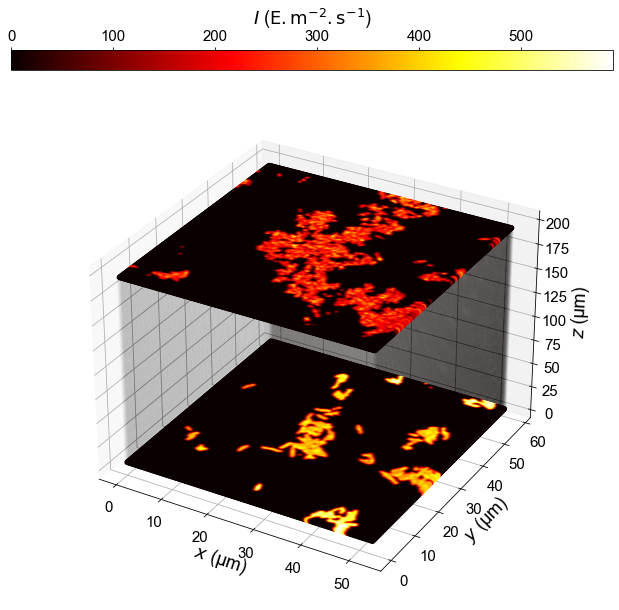

In [11]:
plt.rcParams["figure.figsize"] = [17, 9]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, x, y =  bloc.nonzero()
x = x*0.228
y = y*0.228
col = ax.scatter(x, y, z, c=bloc[bloc!=0], alpha=1, cmap = "hot")

z, x, y =  bloc2.nonzero()
x = x*0.228
y = y*0.228
ax.scatter(x, y, z, c=bloc2[bloc2!=0], alpha=0.006, cmap = "hot")

font = 18
label = 15

cbar = fig.colorbar(col, shrink=0.5, aspect=30, location = 'top')
cbar.set_label(r'$I$ ($\mathrm{E.m^{-2}.s^{-1}}$)',labelpad = 5, fontsize = font)
cbar.ax.tick_params(labelsize=label)

ax.set_xlabel("$x$ (µm)", fontsize = font)
ax.xaxis.set_tick_params(labelsize=label)
ax.set_ylabel("$y$ (µm)", fontsize = font)
ax.yaxis.set_tick_params(labelsize=label)
ax.set_zlabel("$z$ (µm)", fontsize = font, labelpad = 7)
ax.zaxis.set_tick_params(labelsize=label)
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

plt.subplots_adjust(left=0, bottom=0, right=2, top=1, wspace=0, hspace=0)
plt.savefig("../images/bact_cake.png")

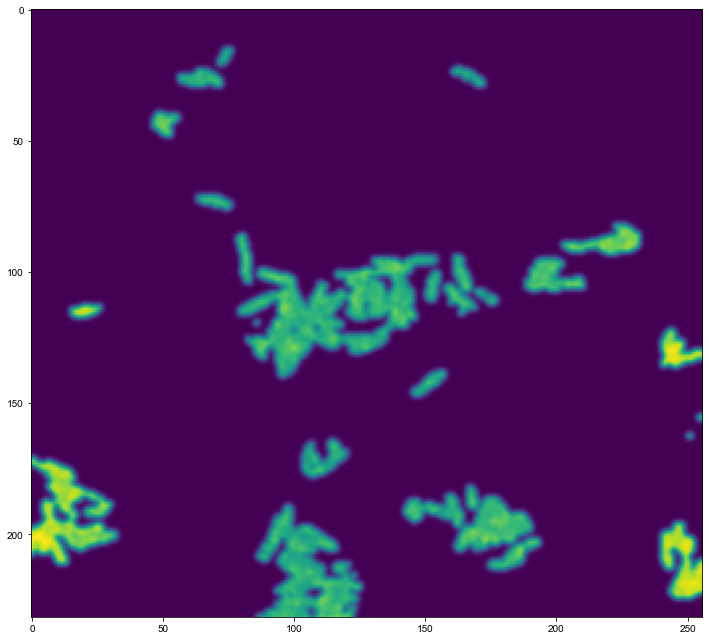

In [12]:
plt.imshow(skimage.filters.gaussian(I_maps[0]))